# <font color = '#00CCFF'> High Value Customer Identification </font>

Project Objective: Find significant customers for the business who make high purchases of their favourite products. The organization wants to roll out a loyalty program to the high-value customers after identification of segments. Use the clustering methodology to segment customers into groups:

Dataset Description: This is a transnational dataset that contains all the transactions occurring between Nov-2016 to Dec-2017 for a UK-based online retail store.

Attribute Description:
- InvoiceNo: Invoice number (A 6-digit integral number uniquely assigned to each transaction)
- StockCode: Product (item) code
- Description: Product (item) name
- Quantity: The quantities of each product (item) per transaction
- InvoiceDate: The day when each transaction was generated
- UnitPrice: Unit price (Product price per unit)
- CustomerID: Customer number (Unique ID assigned to each customer)
- Country: Country name (The name of the country where each customer resides)

# 0. Imports

## 0.1. Libraries

In [2]:
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import scikitplot as skplt
import plotly.express as px
#%matplotlib inline

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

from ydata_profiling import ProfileReport

## 0.2. Functions

In [3]:
# Save intermediate dataset
def save_interim(dataframe, file_name):
   dataframe.to_csv('../data/interim/'+file_name+'.zip', index=False, compression= 'zip')

# Load intermediate dataset
def load_interim(file_name):
   return pd.read_csv('../data/interim/'+file_name, compression='zip')

## 0.3. Load dataset

In [2]:
path = '/home/ezequiel/Documentos/Comunidade_DS/insiders_clustering/data/raw/Ecommerce.zip'
df_raw = pd.read_csv(path, encoding='unicode_escape', compression='zip')
df_raw = df_raw.drop(columns=['Unnamed: 8'], axis=1)

In [3]:
df_raw.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.39,17850.0,United Kingdom


# 1. Descrição dos dados

In [4]:
df1 = df_raw.copy()

## 1.1. Rename columns

In [5]:
df1.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')

In [6]:
cols = ['invoice_no', 'stock_code', 'description', 'quantity', 'invoice_date', 'unit_price', 'customer_id', 'country']
df1.columns = cols

## 1.2. Data dimensions

In [7]:
print(f'Number of rows: {df1.shape[0]}')
print(f'Number of columns: {df1.shape[1]}')

Number of rows: 541909
Number of columns: 8


## 1.3. Data types

InvoiceNo should be a number, but some records have letters

In [8]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

## 1.4. Check NA

In [9]:
df1.isna().sum()

invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
country              0
dtype: int64

## 1.5. Replace NA

In [13]:
df1 = df1.dropna(subset=['description', 'customer_id'])

In [14]:
df1.isna().sum()

invoice_no      0
stock_code      0
description     0
quantity        0
invoice_date    0
unit_price      0
customer_id     0
country         0
dtype: int64

## 1.6. Change dtyper

In [15]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

In [16]:
# invoice_date -> to datetime
df1['invoice_date'] = pd.to_datetime(df1['invoice_date'], format='%d-%b-%y')

# customer_id -> to int
df1['customer_id'] = df1['customer_id'].astype(int)

/tmp/ipykernel_15724/1584764351.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['invoice_date'] = pd.to_datetime(df1['invoice_date'], format='%d-%b-%y')


In [21]:
df1.dtypes

invoice_no              object
stock_code              object
description             object
quantity                 int64
invoice_date    datetime64[ns]
unit_price             float64
customer_id              int64
country                 object
dtype: object

In [25]:
save_interim(dataframe=df1, file_name='df1.csv')

## 1.7. Descriptive statistics

In [22]:
profile = ProfileReport(df=df1, title='Profiling report')

In [23]:
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

# 2. Feature Engineering

In [28]:
# data reference - group by customer
df_ref = df1[['customer_id']].drop_duplicates(ignore_index=True)
df_ref.head()

,customer_id
0,17850
1,13047
2,12583
3,13748
4,15100


**Gross revenue (Faturamento)**

Faturamento = quantidade x preço

In [29]:
df1['gross_revenue'] = df1['quantity'] * df1['unit_price']

/tmp/ipykernel_15724/1698503448.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['gross_revenue'] = df1['quantity'] * df1['unit_price']


In [33]:
# total value of purchases per customer
df_monetary = df1[['customer_id', 'gross_revenue']].groupby('customer_id').sum().reset_index()
df_ref = pd.merge(df_ref, df_monetary, on='customer_id', how='left')

**Recency**

How recent is the last purchase made by each customer.

In [38]:
# find the last purchase date of each customer and subtracts of the overall last purchase date
df_last_purchase = df1[['customer_id', 'invoice_date']].groupby('customer_id').max().reset_index()
df_last_purchase['recency'] = (df_last_purchase['invoice_date'].max() - df_last_purchase['invoice_date']).dt.days
df_ref = pd.merge(df_ref, df_last_purchase, on='customer_id', how='left')

**Frequency**

Consider the unique invoice_no (transaction)

In [60]:
df_freq = df1[['customer_id', 'invoice_no']].drop_duplicates().groupby('customer_id').count().reset_index()
df_ref = pd.merge(df_ref, df_freq, on='customer_id', how='left')
df_ref.head()

,customer_id,gross_revenue,recency,invoice_no
0,17850,5288.63,302,35
1,13047,3079.10,31,18
2,12583,7187.34,2,18
3,13748,948.25,95,5
4,15100,635.10,330,6


In [61]:
df_ref.isna().sum()

customer_id      0
gross_revenue    0
recency          0
invoice_no       0
dtype: int64

In [63]:
save_interim(dataframe=df1, file_name='df2.csv')
save_interim(dataframe=df_ref, file_name='df_ref.csv')

# 3. Variables Filtering

# 4. EDA (Exploratory Data Analysis)

# 5. Data Preparation

# 6. Feature Selection

# 7. Hyperparameter Fine Tunning

In [4]:
df_ref = load_interim(file_name='df_ref.csv.zip')

In [6]:
df7 = df_ref.drop(columns=['customer_id'])
df7.head()

,gross_revenue,recency,invoice_no
0,5288.63,302,35
1,3079.10,31,18
2,7187.34,2,18
3,948.25,95,5
4,635.10,330,6


## 7.1. Within-Cluster Sum of Squares (WSS)

Returns the compactness of the clusters. It is global measure and does not tell if the clusters are well separated or if there is overlaping between them.

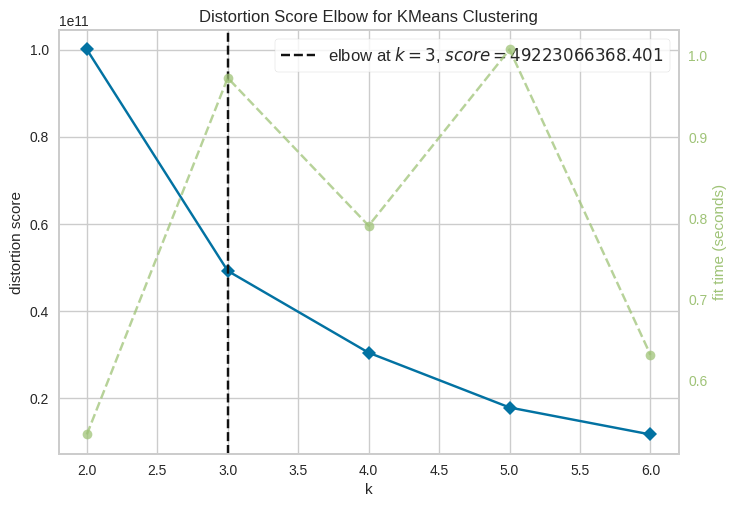

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [22]:
clusters = [2, 3, 4, 5, 6]
model = KMeans(n_init=10)
elbow = KElbowVisualizer(estimator=model, k=clusters)
elbow.fit(df7)
elbow.show()

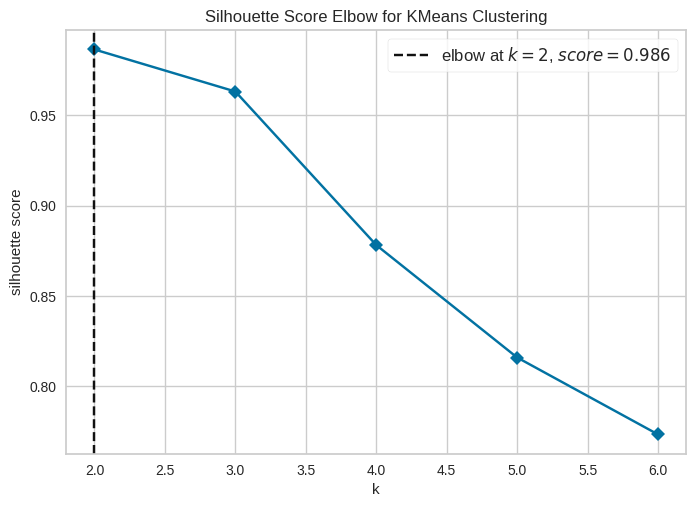

<Axes: title={'center': 'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [12]:
S = KElbowVisualizer(estimator=model, k=clusters, metric='silhouette', timings=False)
S.fit(df7)
S.show()

### Defining 3 as the best number of clusters

## 7.2. Silhouette Score

Measures how well a point fits into its cluster compared to the others.

/home/ezequiel/.pyenv/versions/ins_clustering/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


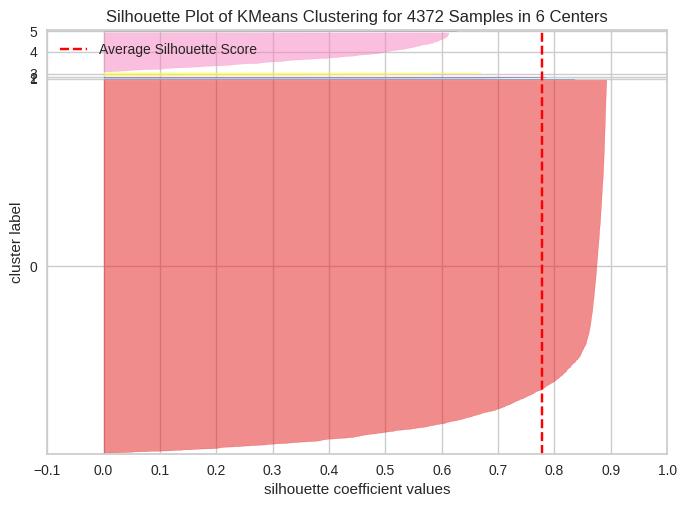

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 4372 Samples in 6 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [25]:
SS = SilhouetteVisualizer(estimator=model)
SS.fit(df7)
SS.show()

# 8. Model Training

## 8.1. K-Means

In [7]:
k = 3

kmeans = KMeans(n_clusters=k, init='random', n_init=10, max_iter=300, random_state=42)
kmeans.fit(df7)
labels = kmeans.predict(df7)

### 8.1.1. Validation

In [8]:
# WSS
print(f'WSS: {kmeans.inertia_}')

# SS
print(f'Silhouette score: {silhouette_score(X=df7, labels=labels, metric="euclidean")}')

WSS: 52830442008.006966


Silhouette score: 0.9494677566681542


# 9. Cluster Analisys

In [16]:
df9 = df_ref.copy()
df9['cluster'] = labels
df9.head()

,customer_id,gross_revenue,recency,invoice_no,cluster
0,17850,5288.63,302,35,0
1,13047,3079.10,31,18,0
2,12583,7187.34,2,18,0
3,13748,948.25,95,5,0
4,15100,635.10,330,6,0


## 9.1. Visualization

In [18]:
fig = px.scatter_3d(data_frame=df9, x='gross_revenue', y='recency', z='invoice_no', color='cluster', width=600, height=600)
fig.show()

## 9.2. Cluster profile

In [32]:
# Number of customers
df_clusters = df9[['customer_id', 'cluster']].groupby('cluster').count().reset_index()

# Average gross revenue
aux1 = df9[['gross_revenue', 'cluster']].groupby('cluster').mean().reset_index()

# Average recency
aux2 = df9[['recency', 'cluster']].groupby('cluster').mean().reset_index()

# Average invoice no
aux3 = df9[['invoice_no', 'cluster']].groupby('cluster').mean().reset_index()

In [44]:
df9[['cluster', 'gross_revenue']].groupby('cluster').sum() / df9['gross_revenue'].sum()

,gross_revenue
cluster,
0,0.716877
1,0.131697
2,0.151426


In [40]:
df_clusters = ((df_clusters.merge(aux1, on='cluster', how='left')).merge(aux2, on='cluster', how='left')).merge(aux3, on='cluster', how='left')
df_clusters

,cluster,customer_id,gross_revenue,recency,invoice_no
0,0,4335,1372.577826,92.257901,4.614533
1,1,6,182181.981667,7.166667,89.000000
2,2,31,40543.517742,13.290323,53.290323


---

**Cluster 1 (candidatos à insiders)**:
- Número de customers: 6 (0,14%)
- Recência média: 7,17
- Média de compras: 89
- Média de receita: US$ 182.181,98
---

**Cluster 2**:
- Número de customers: 31 (0,7%)
- Recência média: 13,3
- Média de compras: 53
- Média de receita: US$ 40.543,52
---

**Cluster 3**:
- Número de customers: 4335 (99,16%)
- Recência média: 92,25
- Média de compras: 4,6
- Média de receita: US$ 1.372,57
---

# 10. Deploy to Production